# Оценка качества генерации текста с помощью метрик
## Трек A: Question Answering (QA).

**Задача:** Оценка качества ответов на вопросы.

**Датасет:** 50-100 вопросов на русском языке с эталонными ответами.

**Метрики:** F1-score, Exact Match, Semantic Similarity, BLEU.

**Особенности:** Фокус на точности фактической информации.

## Часть 1. Подготовка:


Выбрать трек и обосновать выбор (2-3 предложения).
Выбрать 2-3 языковые модели для сравнения (например: GPT-3.5-turbo, Claude-3-haiku, ruGPT-3).

Подготовить датасет согласно выбранному треку:


- Можно использовать готовые датасеты.

- Или создать собственный тематический датасет.

- Указать источник и краткое описание данных.

**Выбираю трек QA**, потому что задача проверки фактической точности ответов является одной из самых насущных при использовании языковых моделей. SberQuAD — идеальный датасет для этого, так как содержит эталонные ответы, выделенные из текста, что позволяет объективно измерять точность с помощью метрик F1 и Exact Match. Это напрямую отвечает требованию "фокус на точности фактической информации".

**Датасет:** SberQuAD https://huggingface.co/datasets/kuznetsoffandrey/sberquad

SberQuAD — это датасет для тестирования понимания текста, состоящий из вопросов, созданных краудворкерами по статьям Википедии. Ответом на вопрос является фрагмент из соответствующей статьи, либо вопрос может остаться без ответа. Оригинальный русскоязычный аналог был представлен на Sberbank Data Science Journey в 2017 году.

**Модели:**

- Qwen2.5-3B-Instruct (качественная)
- Qwen2.5-0.5B-Instruct (лёгкая)

In [1]:
install = False
if install:
  !pip install -q -U transformers accelerate datasets evaluate sentence-transformers sacrebleu

  print("✅ Установка завершена. Перезапустите среду (Runtime → Restart runtime)")

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"GPU: {torch.cuda.get_device_name(0)} | VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# ===== МОДЕЛЬ 1: Qwen2.5-3B (качественная) =====
print("\n📥 Загрузка Qwen2.5-3B-Instruct...")
tokenizer_large = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-3B-Instruct")
model_large = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    dtype=torch.float16,  # ~6 ГБ VRAM
    device_map="auto",
    low_cpu_mem_usage=True
)
print("✅ Qwen2.5-3B-Instruct загружена")

# ===== МОДЕЛЬ 2: Qwen2.5-0.5B (лёгкая) =====
print("\n📥 Загрузка Qwen2.5-0.5B-Instruct...")
tokenizer_small = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
model_small = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-0.5B-Instruct",
    dtype=torch.float16,  # ~1 ГБ VRAM
    device_map="auto",
    low_cpu_mem_usage=True
)
print("✅ Qwen2.5-0.5B-Instruct загружена")

# ===== ТЕСТ ОБЕИХ МОДЕЛЕЙ =====
def generate(model, tokenizer, question, max_new_tokens=50):
    messages = [
        {"role": "system", "content": "Отвечай кратко и точно, только фактами."},
        {"role": "user", "content": question}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.1,
        do_sample=False,
        pad_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()

test_question = "Кто написал роман 'Война и мир'?"
print(f"\n🔍 Тестовый вопрос: {test_question}")
print(f"Qwen2.5-3B:   {generate(model_large, tokenizer_large, test_question)}")
print(f"Qwen2.5-0.5B: {generate(model_small, tokenizer_small, test_question)}")

GPU: Tesla T4 | VRAM: 14.7 GB

📥 Загрузка Qwen2.5-3B-Instruct...


Loading weights:   0%|          | 0/434 [00:00<?, ?it/s]

✅ Qwen2.5-3B-Instruct загружена

📥 Загрузка Qwen2.5-0.5B-Instruct...


Loading weights:   0%|          | 0/290 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Qwen2.5-0.5B-Instruct загружена

🔍 Тестовый вопрос: Кто написал роман 'Война и мир'?
Qwen2.5-3B:   Александр Пушкин написал роман «Война и мир».
Qwen2.5-0.5B: Роман "Война и мир" написал В.Г. Маяковский.


## Часть 2. Реализация метрик

1. Semantic Similarity.
2. Время генерации ответа.
3. Длина сгенерированного текста.
4. F1-score
5. Exact Match
6. BLEU

In [3]:
import torch
import time
import re
import json
import csv
from datasets import load_dataset
from evaluate import load
from sacrebleu import corpus_bleu
from sentence_transformers import SentenceTransformer
import numpy as np

# ===== 1. ЗАГРУЗКА ДАТАСЕТА =====
print("📥 Загрузка SberQUAD (100 примеров)...")
dataset = load_dataset("kuznetsoffandrey/sberquad", split="train[:100]")
print(f"✅ Загружено {len(dataset)} примеров\n")

# ===== 2. ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ =====

def normalize_text(text):
    """Нормализация текста для сравнения (регистр, пунктуация)"""
    text = text.lower()
    text = re.sub(r'[^\w\sа-яё]', '', text)  # Удаляем пунктуацию, оставляем кириллицу
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_f1(text):
    """Токенизация для F1-score (слова через пробелы)"""
    return normalize_text(text).split()

def compute_f1(prediction, ground_truth):
    """Вычисление F1-score между ответами"""
    pred_tokens = tokenize_f1(prediction)
    gt_tokens = tokenize_f1(ground_truth)

    if not pred_tokens or not gt_tokens:
        return 0.0

    common = set(pred_tokens) & set(gt_tokens)
    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gt_tokens)
    return 2 * (precision * recall) / (precision + recall)

def compute_exact_match(prediction, ground_truth):
    """Exact Match (регистронезависимый)"""
    return float(normalize_text(prediction) == normalize_text(ground_truth))

def compute_bleu(prediction, ground_truth):
    """BLEU-1 score (оптимален для коротких ответов)"""
    return corpus_bleu([prediction], [[ground_truth]], tokenize='none').score

# ===== 3. ЗАГРУЗКА МОДЕЛИ ДЛЯ SEMANTIC SIMILARITY =====
print("📥 Загрузка модели для семантического сходства...")
semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Модель загружена\n")

def compute_semantic_similarity(prediction, ground_truth):
    """Косинусное сходство между эмбеддингами"""
    embeddings = semantic_model.encode([prediction, ground_truth], convert_to_tensor=True)
    similarity = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0)
    return similarity.item()

# ===== 4. ГЕНЕРАЦИЯ ОТВЕТА С ЗАМЕРОМ ВРЕМЕНИ =====
def generate_answer(model, tokenizer, question, context=None, max_new_tokens=50):
    """
    Генерация ответа с замером времени.
    Для SberQUAD можно использовать контекст для улучшения качества.
    """
    start_time = time.time()

    # Формируем промпт в стиле модели
    if context:
        prompt = f"Контекст: {context}\n\nВопрос: {question}\n\nОтветь кратко и точно:"
    else:
        prompt = f"Вопрос: {question}\n\nОтветь кратко и точно:"

    messages = [
        {"role": "system", "content": "Ты — полезный ассистент. Отвечай кратко и точно, только фактами."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=0.1,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    answer = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    generation_time = time.time() - start_time
    token_count = outputs[0][inputs.input_ids.shape[1]:].shape[0]

    return answer.strip(), generation_time, token_count

# ===== 5. ОЦЕНКА МОДЕЛИ НА ДАТАСЕТЕ =====
def evaluate_model(model, tokenizer, model_name, num_samples=100):
    print(f"\n🔍 Оценка модели: {model_name}")
    print("=" * 70)

    results = []
    total_em = 0
    total_f1 = 0
    total_bleu = 0
    total_semantic = 0
    total_time = 0
    total_tokens = 0

    for i in range(min(num_samples, len(dataset))):
        example = dataset[i]
        question = example['question']
        context = example['context']
        ground_truth = example['answers']['text'][0]  # Берём первый эталонный ответ

        # Генерация ответа
        try:
            prediction, gen_time, token_count = generate_answer(
                model, tokenizer, question, context, max_new_tokens=50
            )
        except Exception as e:
            print(f"⚠️ Ошибка на примере {i}: {str(e)}")
            prediction, gen_time, token_count = "", 0, 0

        # Вычисление метрик
        em = compute_exact_match(prediction, ground_truth)
        f1 = compute_f1(prediction, ground_truth)
        bleu = compute_bleu(prediction, ground_truth)
        semantic = compute_semantic_similarity(prediction, ground_truth) if prediction else 0.0

        # Накопление для усреднения
        total_em += em
        total_f1 += f1
        total_bleu += bleu
        total_semantic += semantic
        total_time += gen_time
        total_tokens += token_count

        # Сохранение результата
        results.append({
            "id": i,
            "question": question,
            "context": context[:100] + "..." if len(context) > 100 else context,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "exact_match": em,
            "f1_score": f1,
            "bleu": bleu,
            "semantic_similarity": semantic,
            "generation_time_sec": gen_time,
            "token_count": token_count
        })

        # Прогресс каждые 10 примеров
        if (i + 1) % 10 == 0:
            print(f"Пример {i+1}/{num_samples} | EM: {em:.1f} | F1: {f1:.2f} | Ответ: {prediction[:40]}...")

    # Усреднённые метрики
    avg_em = total_em / num_samples * 100
    avg_f1 = total_f1 / num_samples * 100
    avg_bleu = total_bleu / num_samples
    avg_semantic = total_semantic / num_samples * 100
    avg_time = total_time / num_samples
    avg_tokens = total_tokens / num_samples

    print("\n" + "=" * 70)
    print(f"📈 ИТОГОВЫЕ РЕЗУЛЬТАТЫ ({model_name}):")
    print("=" * 70)
    print(f"Exact Match:          {avg_em:.2f}%")
    print(f"F1-score:             {avg_f1:.2f}%")
    print(f"BLEU-1:               {avg_bleu:.2f}")
    print(f"Semantic Similarity:  {avg_semantic:.2f}%")
    print(f"Среднее время генерации: {avg_time:.3f} сек")
    print(f"Средняя длина ответа: {avg_tokens:.1f} токенов")
    print("=" * 70)

    return {
        "model_name": model_name,
        "exact_match": avg_em,
        "f1_score": avg_f1,
        "bleu": avg_bleu,
        "semantic_similarity": avg_semantic,
        "avg_generation_time": avg_time,
        "avg_token_count": avg_tokens,
        "detailed_results": results
    }

# ===== 6. ЗАПУСК ОЦЕНКИ ДЛЯ ОБЕИХ МОДЕЛЕЙ =====
results_large = evaluate_model(model_large, tokenizer_large, "Qwen2.5-3B", num_samples=50)
results_small = evaluate_model(model_small, tokenizer_small, "Qwen2.5-0.5B", num_samples=50)

# ===== 7. СРАВНИТЕЛЬНАЯ ТАБЛИЦА =====
print("\n" + "=" * 70)
print("📊 СРАВНЕНИЕ МОДЕЛЕЙ")
print("=" * 70)
print(f"{'Метрика':<25} | {'Qwen2.5-3B':>12} | {'Qwen2.5-0.5B':>12}")
print("-" * 70)
print(f"{'Exact Match (%)':<25} | {results_large['exact_match']:>12.2f} | {results_small['exact_match']:>12.2f}")
print(f"{'F1-score (%)':<25} | {results_large['f1_score']:>12.2f} | {results_small['f1_score']:>12.2f}")
print(f"{'BLEU-1':<25} | {results_large['bleu']:>12.2f} | {results_small['bleu']:>12.2f}")
print(f"{'Semantic Sim (%)':<25} | {results_large['semantic_similarity']:>12.2f} | {results_small['semantic_similarity']:>12.2f}")
print(f"{'Время генерации (сек)':<25} | {results_large['avg_generation_time']:>12.3f} | {results_small['avg_generation_time']:>12.3f}")
print(f"{'Длина ответа (токены)':<25} | {results_large['avg_token_count']:>12.1f} | {results_small['avg_token_count']:>12.1f}")
print("=" * 70)

# ===== 8. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В CSV =====
def save_results_to_csv(results, filename):
    with open(filename, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=[
            "id", "question", "ground_truth", "prediction",
            "exact_match", "f1_score", "bleu", "semantic_similarity",
            "generation_time_sec", "token_count"
        ])
        writer.writeheader()
        for r in results['detailed_results']:
            writer.writerow({
                "id": r["id"],
                "question": r["question"],
                "ground_truth": r["ground_truth"],
                "prediction": r["prediction"],
                "exact_match": f"{r['exact_match']:.4f}",
                "f1_score": f"{r['f1_score']:.4f}",
                "bleu": f"{r['bleu']:.4f}",
                "semantic_similarity": f"{r['semantic_similarity']:.4f}",
                "generation_time_sec": f"{r['generation_time_sec']:.4f}",
                "token_count": r["token_count"]
            })
    print(f"\n✅ Результаты сохранены в {filename}")

save_results_to_csv(results_large, "results_qwen2.5-3b.csv")
save_results_to_csv(results_small, "results_qwen2.5-0.5b.csv")

print("\n🎉 Оценка завершена! Все метрики рассчитаны и сохранены.")

📥 Загрузка SberQUAD (100 примеров)...
✅ Загружено 100 примеров

📥 Загрузка модели для семантического сходства...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Модель загружена


🔍 Оценка модели: Qwen2.5-3B
Пример 10/50 | EM: 1.0 | F1: 1.00 | Ответ: Для видов, кормящихся грубой растительно...
Пример 20/50 | EM: 0.0 | F1: 0.53 | Ответ: Стоимость аренды комплекса Байконур сост...
Пример 30/50 | EM: 0.0 | F1: 0.60 | Ответ: Нужна была необходимость в разделении сф...
Пример 40/50 | EM: 0.0 | F1: 0.53 | Ответ: Парижский коворкинг La Ruche тщательно о...
Пример 50/50 | EM: 0.0 | F1: 0.46 | Ответ: Министерство юстиции США продолжает наст...

📈 ИТОГОВЫЕ РЕЗУЛЬТАТЫ (Qwen2.5-3B):
Exact Match:          18.00%
F1-score:             54.77%
BLEU-1:               16.65
Semantic Similarity:  72.97%
Среднее время генерации: 1.227 сек
Средняя длина ответа: 21.6 токенов

🔍 Оценка модели: Qwen2.5-0.5B
Пример 10/50 | EM: 1.0 | F1: 1.00 | Ответ: Для видов, кормящихся грубой растительно...
Пример 20/50 | EM: 0.0 | F1: 0.27 | Ответ: Стоимость аренды комплекса Байконур сост...
Пример 30/50 | EM: 0.0 | F1: 0.56 | Ответ: Прибытие Колумба из Вест-Индии вызвало н...
Пр

### qwen2.5-3b

In [4]:
import pandas as pd
df1 = pd.read_csv("/content/results_qwen2.5-3b.csv", index_col=0)
df1.sample(2)

,question,ground_truth,prediction,exact_match,f1_score,bleu,semantic_similarity,generation_time_sec,token_count
id,,,,,,,,,
46,Целлюлоза в клеточных стенках организована в ....,в микрофибриллы,Микрофибриллы,0.0,0.6667,0.0000,0.8718,0.5694,8
23,Во сколько обходится содержание и эксплуатация...,"в 10,16 млрд рублей в год","10,16 млрд рублей в год.",0.0,0.9091,54.7518,0.9752,0.7750,13


#### Лучшие результаты

In [5]:
print(df1.sort_values(by="semantic_similarity").tail(5).loc[:, :"prediction"].to_string())

                                                       question                                     ground_truth                                        prediction
id                                                                                                                                                                
16     На какой период был арендован Россией комплекс Байконур                                      до 2050 года                                     До 2050 года.
9       Для каких видов млекопитающих особо важна слепая кишка?  Для видов, кормящихся грубой растительной пищей  Для видов, кормящихся грубой растительной пищей.
30  Когда католические короли получили от Александра VI буллу ?                                  4 мая 1493 года                                   4 мая 1493 года
41       Какой коворкинг предоставляет рабочие места писателям?                                        Paragraph                                         Paragraph
33          Какая стра

#### Худшие результаты

In [6]:
print(df1.sort_values(by="semantic_similarity").head(5).loc[:, :"prediction"].to_string())

                                                                                    question                  ground_truth                                                                                                                                                        prediction
id                                                                                                                                                                                                                                                                                          
35                                       Когда начались нападения японцев на русских солдат?  ночью на 27 января 1904 года                           Нападения японцев на русских солдат не упоминается в данном контексте. Контекст описывает боевые столкновения между военными кораблями.
47                                 За что банк должен нести ответственность, по мнению суда?                за свои деяния  Банк должен нести отв

### qwen2.5-0.5b

In [7]:
df2 = pd.read_csv("/content/results_qwen2.5-0.5b.csv", index_col=0)

#### Лучшие результаты

In [8]:
print(df2.sort_values(by="semantic_similarity").tail(5).loc[:, :"prediction"].to_string())

                                                                                   question                          ground_truth                            prediction
id                                                                                                                                                                     
30                              Когда католические короли получили от Александра VI буллу ?                       4 мая 1493 года                       4 мая 1493 года
3                                   что относится к числу древнейших растительных остатков?  скопления графито-углистого вещества  скопления графито-углистого вещества
16                                 На какой период был арендован Россией комплекс Байконур                           до 2050 года                          до 2050 года
33                                      Какая страна являлась союзником Японии в 1904 году?                        Великобритания                        Великоб

#### Худшие резульатаы

In [9]:
print(df2.sort_values(by="semantic_similarity").head(5).loc[:, :"prediction"].to_string())

                                                                                    question         ground_truth                                                                                                                                        prediction
id                                                                                                                                                                                                                                                                 
44  В каких местах индивидуальные макромолекулы в микрофибрилле начинаются и заканчиваются ?      в разных местах  Макромолекулы в микрофибрилле начинаются и заканчиваются в разных местах, поэтому длина микрофибриллы превышает длину отдельных макromoles целлю
47                                 За что банк должен нести ответственность, по мнению суда?       за свои деяния                  Банк должен нести ответственность за свои деяния, связанные с предоставлением налоговых д

## Часть 3. Эксперименты:


Протестировать модели на подготовленном датасете:
- Влияние длины промпта на качество.
- Сравнение zero-shot vs few-shot промптинга.
- Анализ типичных ошибок моделей.
- A/B-тестирование разных форматов промптов.
- Анализ влияния температуры генерации.

In [10]:
install = False
if install:
  !pip install -q matplotlib seaborn pandas

  print("✅ Зависимости для визуализации установлены")

📥 Загрузка данных...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Данные и модель семантики загружены

🔬 ЭКСПЕРИМЕНТ 1: Влияние длины промпта на качество

➡️  Qwen2.5-3B:
краткий      | F1:  5.55% | EM:  0.00% | Время: 1.875с
средний      | F1:  6.16% | EM:  0.00% | Время: 2.046с
развёрнутый  | F1: 60.15% | EM: 10.00% | Время: 1.716с

✅ График сохранён: prompt_length_Qwen2.5-3B.png


➡️  Qwen2.5-0.5B:
краткий      | F1:  8.15% | EM:  0.00% | Время: 1.395с
средний      | F1:  6.44% | EM:  0.00% | Время: 1.230с
развёрнутый  | F1: 50.63% | EM: 10.00% | Время: 0.848с

✅ График сохранён: prompt_length_Qwen2.5-0.5B.png


🔬 ЭКСПЕРИМЕНТ 2: Zero-shot vs Few-shot промптинг

➡️  Qwen2.5-3B:
zero-shot    | F1: 50.79% | EM:  0.00%
few-shot     | F1: 59.48% | EM: 20.00%

✅ График сохранён: few_shot_Qwen2.5-3B.png

🔍 Примеры ответов (первый вопрос):
Вопрос: чем представлены органические остатки?...
Эталон: известковыми выделениями сине-зелёных водорослей
Zero-shot:  Органические остатки представлены извест...
Few-shot:   Известковыми выделениями сине-зелёных во..

The following generation flags are not valid and may be ignored: ['temperature', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


контекстный  | F1: 45.74%

✅ График форматов сохранён: prompt_formats_Qwen2.5-0.5B.png

🔬 ЭКСПЕРИМЕНТ 5: Влияние температуры генерации

➡️  Qwen2.5-3B:
temp=0.0  | F1: 42.15% | Консистентность: 100.00%
temp=0.1  | F1: 42.15% | Консистентность: 100.00%
temp=0.3  | F1: 42.15% | Консистентность: 98.82%
temp=0.7  | F1: 49.63% | Консистентность: 95.31%
temp=1.0  | F1: 42.15% | Консистентность: 95.12%

✅ График температуры сохранён: temperature_Qwen2.5-3B.png

➡️  Qwen2.5-0.5B:
temp=0.0  | F1: 29.71% | Консистентность: 100.00%
temp=0.1  | F1: 29.71% | Консистентность: 90.21%
temp=0.3  | F1: 45.15% | Консистентность: 94.57%
temp=0.7  | F1: 25.33% | Консистентность: 64.23%
temp=1.0  | F1:  5.00% | Консистентность: 41.40%

✅ График температуры сохранён: temperature_Qwen2.5-0.5B.png

📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ
      Модель Лучший формат F1 (лучший формат) Оптим. темп. F1 (оптим. темп.) Few-shot прирост
  Qwen2.5-3B   контекстный              48.6%          0.7             49.6% 

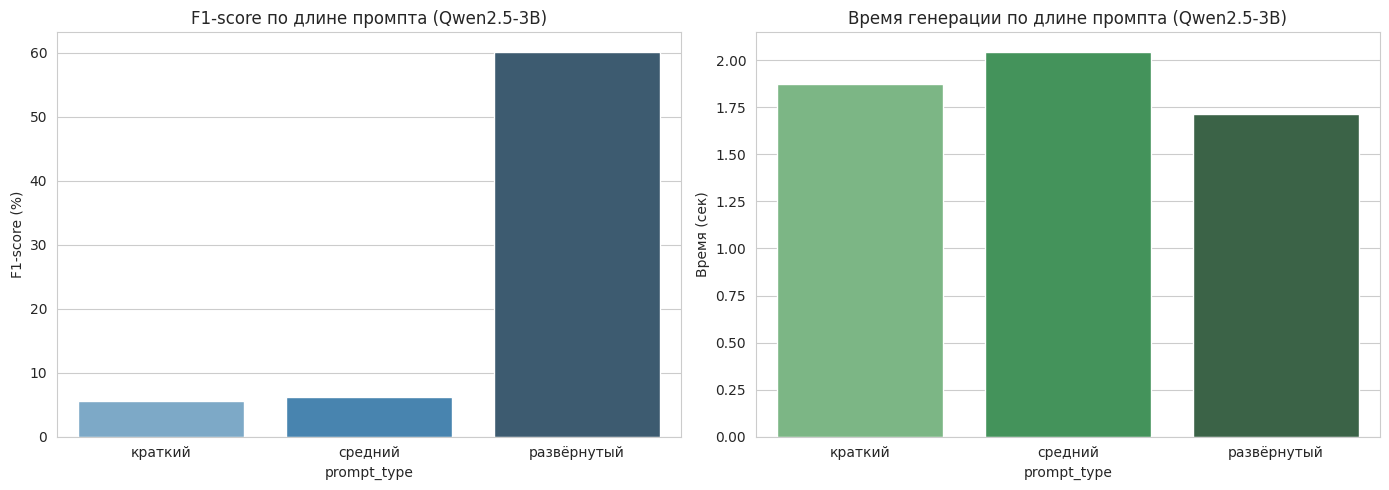

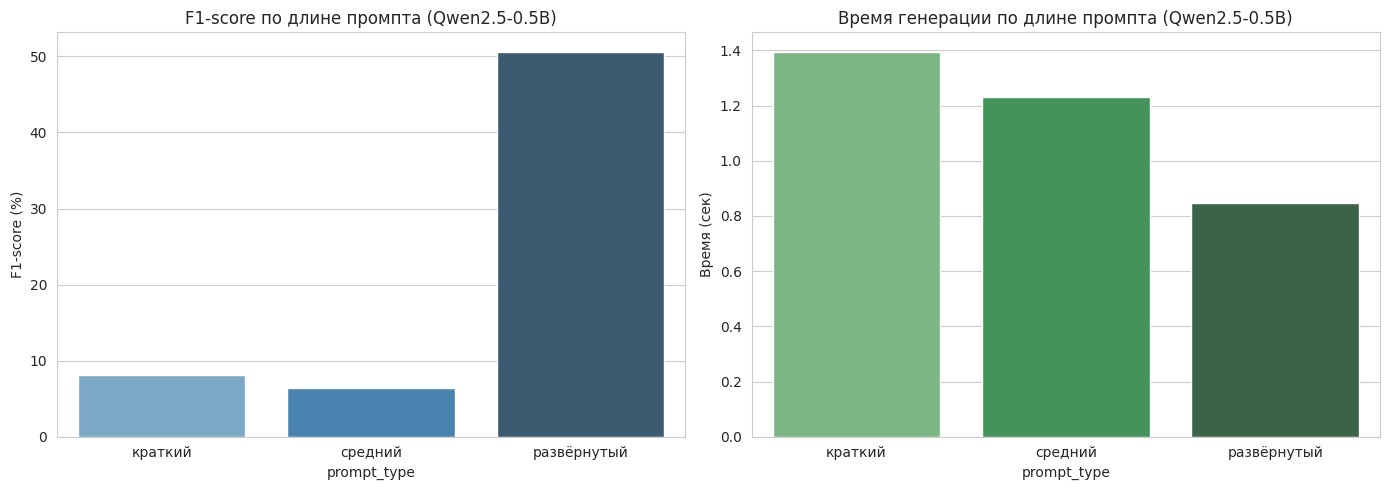

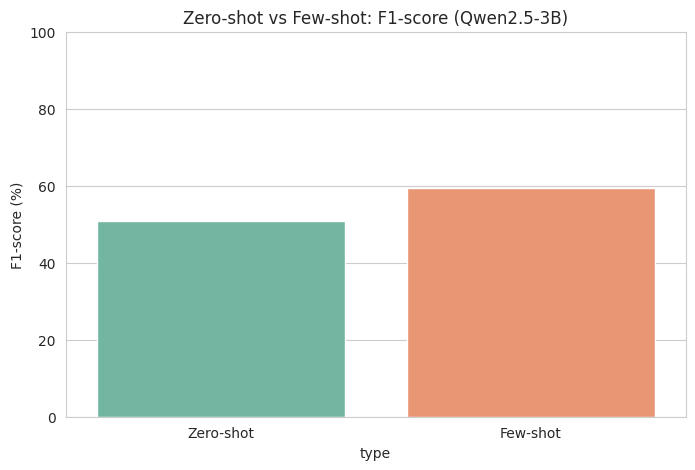

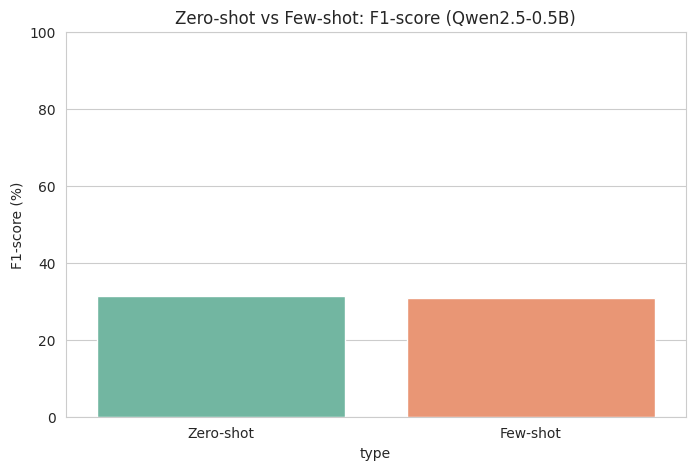

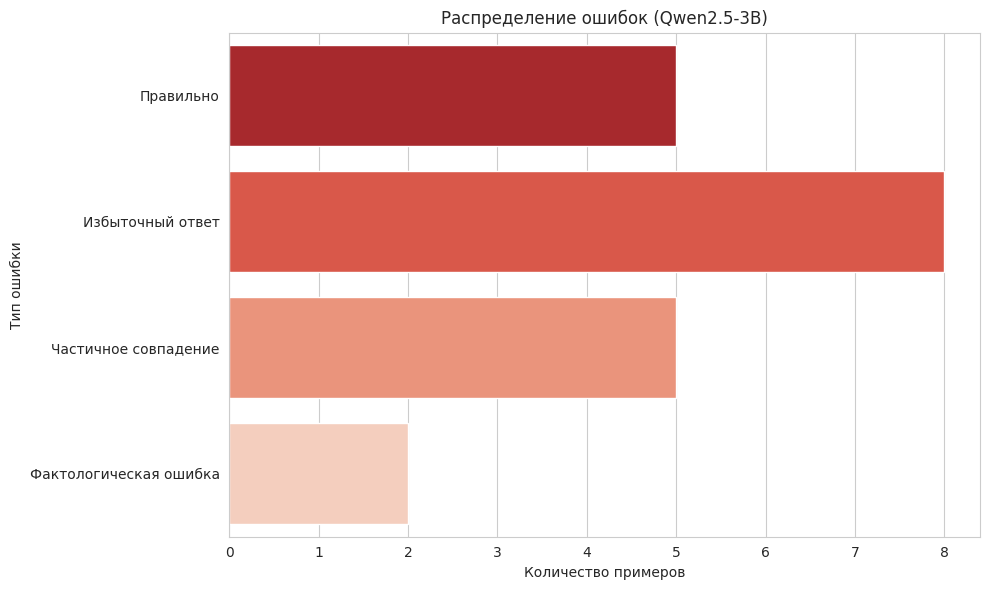

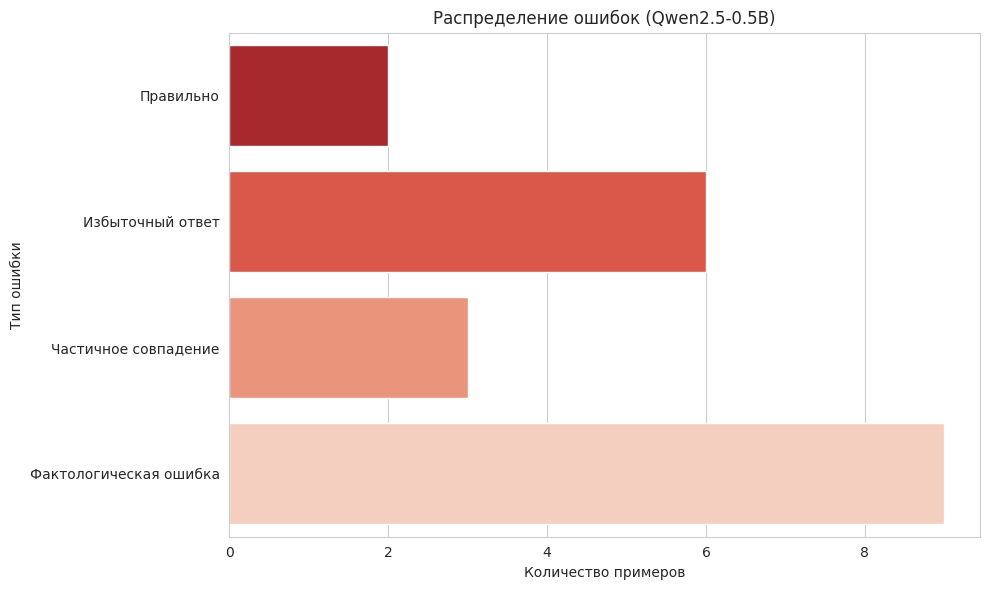

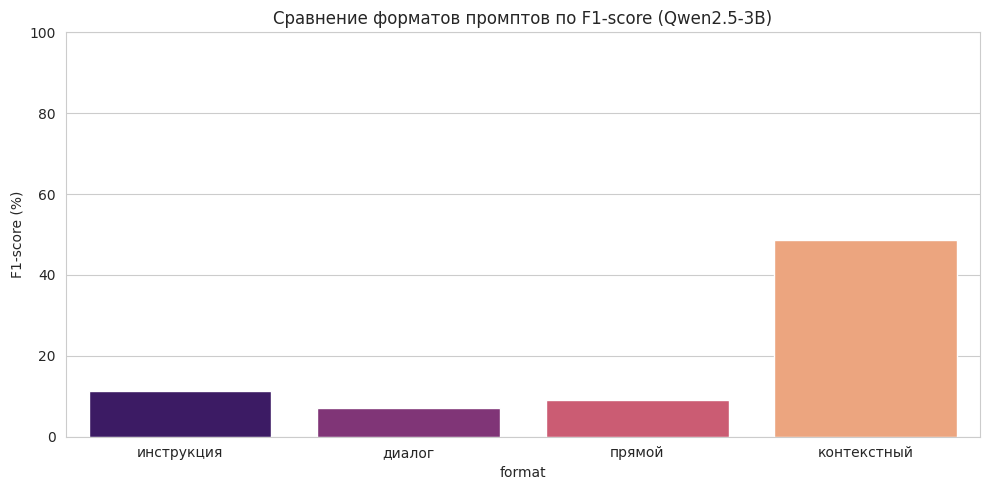

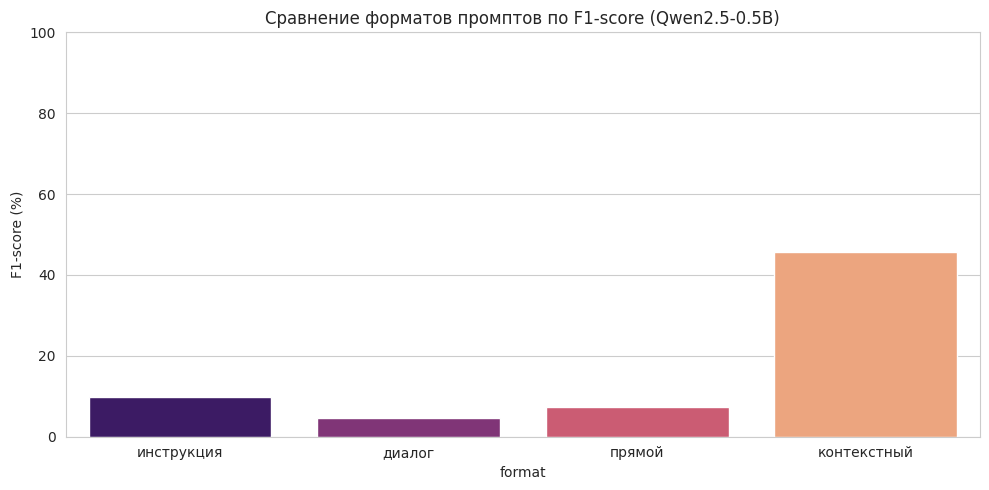

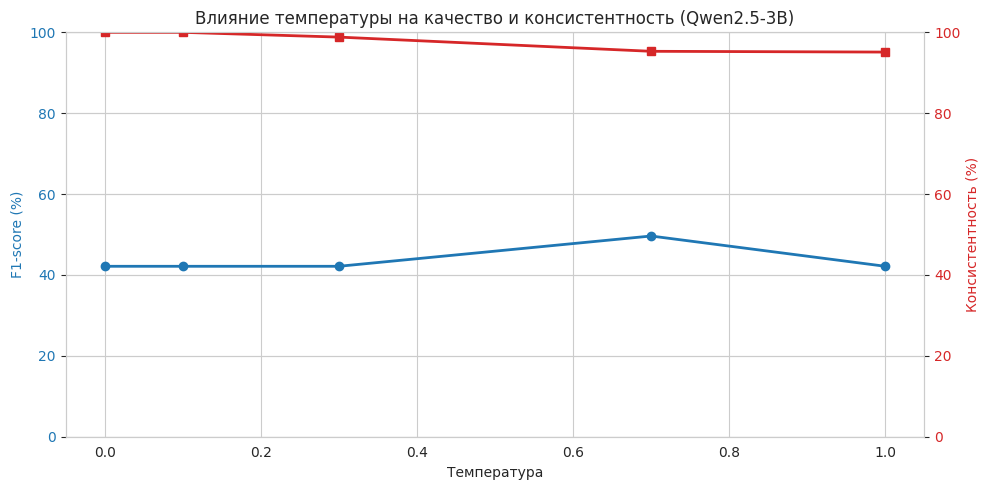

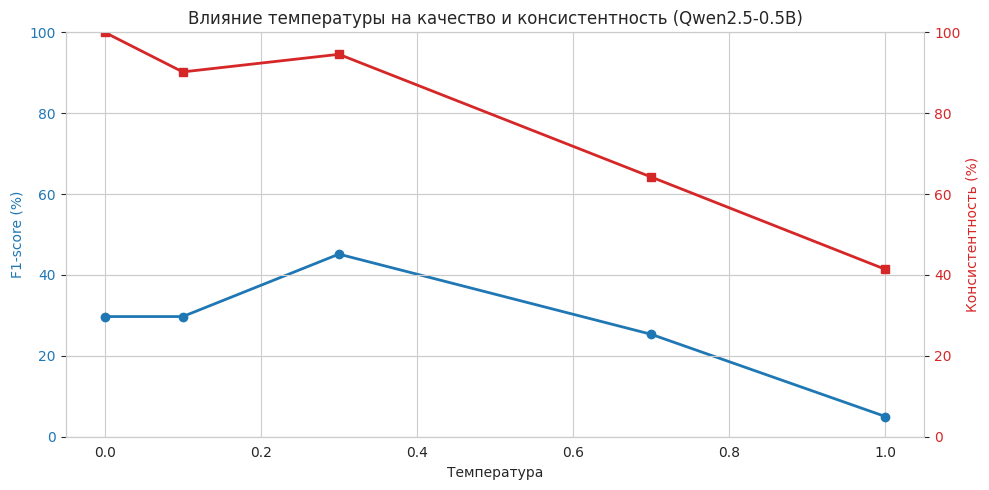

In [11]:
import torch
import time
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
import numpy as np

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'  # Поддержка кириллицы в графиках
plt.rcParams['figure.figsize'] = (12, 6)

# ===== ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ =====
def normalize_text(text):
    """Нормализация текста для сравнения"""
    if not text:
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\sа-яё]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def compute_f1(prediction, ground_truth):
    """F1-score на уровне слов"""
    pred_tokens = normalize_text(prediction).split()
    gt_tokens = normalize_text(ground_truth).split()

    if not pred_tokens or not gt_tokens:
        return 0.0

    common = set(pred_tokens) & set(gt_tokens)
    if not common:
        return 0.0

    precision = len(common) / len(pred_tokens)
    recall = len(common) / len(gt_tokens)
    return 2 * (precision * recall) / (precision + recall)

def compute_exact_match(prediction, ground_truth):
    """Exact Match"""
    return float(normalize_text(prediction) == normalize_text(ground_truth))

def compute_semantic_similarity(model, prediction, ground_truth):
    """Семантическое сходство"""
    if not prediction or not ground_truth:
        return 0.0
    embeddings = model.encode([prediction, ground_truth], convert_to_tensor=True)
    similarity = torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0)
    return similarity.item()

def generate_answer(model, tokenizer, prompt, max_new_tokens=50, temperature=0.1):
    """Генерация ответа с замером времени"""
    start_time = time.time()

    messages = [
        {"role": "system", "content": "Отвечай кратко и точно, только фактами."},
        {"role": "user", "content": prompt}
    ]

    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=temperature > 0.0,
            pad_token_id=tokenizer.eos_token_id,
            top_p=0.95 if temperature > 0.0 else 1.0
        )

    answer = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    generation_time = time.time() - start_time
    token_count = outputs[0][inputs.input_ids.shape[1]:].shape[0]

    return answer.strip(), generation_time, token_count

# ===== ЗАГРУЗКА ДАТАСЕТА И МОДЕЛИ ДЛЯ СЕМАНТИКИ =====
print("📥 Загрузка данных...")
dataset = load_dataset("kuznetsoffandrey/sberquad", split="train[:50]")  # 50 примеров для экспериментов
semantic_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("✅ Данные и модель семантики загружены\n")

# ===== ЭКСПЕРИМЕНТ 1: ВЛИЯНИЕ ДЛИНЫ ПРОМПТА =====
print("=" * 70)
print("🔬 ЭКСПЕРИМЕНТ 1: Влияние длины промпта на качество")
print("=" * 70)

prompt_lengths = {
    "краткий": "Вопрос: {question}\nОтвет:",
    "средний": "Ответь кратко на вопрос: {question}\nОтвет:",
    "развёрнутый": "Контекст: {context}\n\nВопрос: {question}\n\nОтветь точно и кратко, используя информацию из контекста:"
}

def run_prompt_length_experiment(model, tokenizer, model_name):
    results = []

    for prompt_type, template in prompt_lengths.items():
        total_f1 = 0
        total_em = 0
        total_time = 0

        for i in range(10):  # 10 примеров для быстрого теста
            ex = dataset[i]
            prompt = template.format(question=ex['question'], context=ex['context'])
            pred, gen_time, _ = generate_answer(model, tokenizer, prompt, max_new_tokens=50)

            f1 = compute_f1(pred, ex['answers']['text'][0])
            em = compute_exact_match(pred, ex['answers']['text'][0])

            total_f1 += f1
            total_em += em
            total_time += gen_time

        avg_f1 = total_f1 / 10 * 100
        avg_em = total_em / 10 * 100
        avg_time = total_time / 10

        results.append({
            "prompt_type": prompt_type,
            "avg_f1": avg_f1,
            "avg_em": avg_em,
            "avg_time": avg_time
        })

        print(f"{prompt_type:<12} | F1: {avg_f1:5.2f}% | EM: {avg_em:5.2f}% | Время: {avg_time:.3f}с")

    # Визуализация
    df = pd.DataFrame(results)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    sns.barplot(data=df, x='prompt_type', y='avg_f1', hue='prompt_type', palette='Blues_d', dodge=False, legend=False, ax=axes[0])
    axes[0].set_title(f'F1-score по длине промпта ({model_name})')
    axes[0].set_ylabel('F1-score (%)')

    sns.barplot(data=df, x='prompt_type', y='avg_time', hue='prompt_type', palette='Greens_d', dodge=False, legend=False, ax=axes[1])
    axes[1].set_title(f'Время генерации по длине промпта ({model_name})')
    axes[1].set_ylabel('Время (сек)')

    plt.tight_layout()
    plt.savefig(f'prompt_length_{model_name}.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ График сохранён: prompt_length_{model_name}.png\n")

    return results

# Запуск для обеих моделей
print("\n➡️  Qwen2.5-3B:")
results_large_prompt = run_prompt_length_experiment(model_large, tokenizer_large, "Qwen2.5-3B")

print("\n➡️  Qwen2.5-0.5B:")
results_small_prompt = run_prompt_length_experiment(model_small, tokenizer_small, "Qwen2.5-0.5B")

# ===== ЭКСПЕРИМЕНТ 2: ZERO-SHOT VS FEW-SHOT =====
print("\n" + "=" * 70)
print("🔬 ЭКСПЕРИМЕНТ 2: Zero-shot vs Few-shot промптинг")
print("=" * 70)

# Примеры для few-shot (из датасета)
few_shot_examples = [
    {
        "question": "Кто написал роман 'Преступление и наказание'?",
        "context": "Фёдор Михайлович Достоевский — русский писатель, мыслитель, философ и публицист.",
        "answer": "Фёдор Михайлович Достоевский"
    },
    {
        "question": "Столица Франции?",
        "context": "Париж — столица Франции, административный центр департамента Сена и региона Иль-де-Франс.",
        "answer": "Париж"
    }
]

def create_zero_shot_prompt(question, context):
    return f"Контекст: {context}\n\nВопрос: {question}\n\nОтветь кратко:"

def create_few_shot_prompt(question, context):
    prompt = "Примеры правильных ответов:\n\n"
    for ex in few_shot_examples:
        prompt += f"Контекст: {ex['context']}\nВопрос: {ex['question']}\nОтвет: {ex['answer']}\n\n"
    prompt += f"Теперь ответь на новый вопрос:\n\nКонтекст: {context}\nВопрос: {question}\n\nОтвет:"
    return prompt

def run_few_shot_experiment(model, tokenizer, model_name):
    results = {"zero-shot": [], "few-shot": []}

    for prompt_type in ["zero-shot", "few-shot"]:
        total_f1 = 0
        total_em = 0

        for i in range(10):
            ex = dataset[i]
            if prompt_type == "zero-shot":
                prompt = create_zero_shot_prompt(ex['question'], ex['context'])
            else:
                prompt = create_few_shot_prompt(ex['question'], ex['context'])

            pred, _, _ = generate_answer(model, tokenizer, prompt, max_new_tokens=50)
            f1 = compute_f1(pred, ex['answers']['text'][0])
            em = compute_exact_match(pred, ex['answers']['text'][0])

            total_f1 += f1
            total_em += em
            results[prompt_type].append({
                "question": ex['question'][:50] + "...",
                "prediction": pred[:40] + ("..." if len(pred) > 40 else ""),
                "ground_truth": ex['answers']['text'][0],
                "f1": f1
            })

        avg_f1 = total_f1 / 10 * 100
        avg_em = total_em / 10 * 100
        print(f"{prompt_type:<12} | F1: {avg_f1:5.2f}% | EM: {avg_em:5.2f}%")

    # Визуализация сравнения
    df = pd.DataFrame([
        {"type": "Zero-shot", "f1": sum(r["f1"] for r in results["zero-shot"]) / 10 * 100},
        {"type": "Few-shot", "f1": sum(r["f1"] for r in results["few-shot"]) / 10 * 100}
    ])

    plt.figure(figsize=(8, 5))
    sns.barplot(data=df, x='type', y='f1', hue='type', palette='Set2', dodge=False, legend=False)
    plt.title(f'Zero-shot vs Few-shot: F1-score ({model_name})')
    plt.ylabel('F1-score (%)')
    plt.ylim(0, 100)
    plt.savefig(f'few_shot_{model_name}.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ График сохранён: few_shot_{model_name}.png")

    # Примеры ответов
    print("\n🔍 Примеры ответов (первый вопрос):")
    print(f"Вопрос: {results['zero-shot'][0]['question']}")
    print(f"Эталон: {results['zero-shot'][0]['ground_truth']}")
    print(f"Zero-shot:  {results['zero-shot'][0]['prediction']}")
    print(f"Few-shot:   {results['few-shot'][0]['prediction']}")

    return results

print("\n➡️  Qwen2.5-3B:")
results_large_fewshot = run_few_shot_experiment(model_large, tokenizer_large, "Qwen2.5-3B")

print("\n➡️  Qwen2.5-0.5B:")
results_small_fewshot = run_few_shot_experiment(model_small, tokenizer_small, "Qwen2.5-0.5B")

# ===== ЭКСПЕРИМЕНТ 3: АНАЛИЗ ТИПИЧНЫХ ОШИБОК =====
print("\n" + "=" * 70)
print("🔬 ЭКСПЕРИМЕНТ 3: Анализ типичных ошибок моделей")
print("=" * 70)

def classify_error(prediction, ground_truth):
    """Классификация типа ошибки"""
    pred_norm = normalize_text(prediction)
    gt_norm = normalize_text(ground_truth)

    if not prediction:
        return "Пустой ответ"

    if pred_norm == gt_norm:
        return "Правильно"

    # Проверка на избыточность
    if gt_norm in pred_norm and len(pred_norm) > len(gt_norm) * 1.5:
        return "Избыточный ответ"

    # Проверка на неполноту
    if pred_norm in gt_norm and len(pred_norm) < len(gt_norm) * 0.7:
        return "Неполный ответ"

    # Проверка на фактологическую ошибку (частичное совпадение)
    pred_words = set(pred_norm.split())
    gt_words = set(gt_norm.split())
    overlap = len(pred_words & gt_words) / max(len(gt_words), 1)

    if overlap > 0.5:
        return "Частичное совпадение"
    else:
        return "Фактологическая ошибка"

def analyze_errors(model, tokenizer, model_name, num_samples=20):
    error_stats = {
        "Правильно": 0,
        "Пустой ответ": 0,
        "Избыточный ответ": 0,
        "Неполный ответ": 0,
        "Частичное совпадение": 0,
        "Фактологическая ошибка": 0
    }
    error_examples = []

    for i in range(num_samples):
        ex = dataset[i]
        prompt = f"Контекст: {ex['context']}\n\nВопрос: {ex['question']}\n\nОтветь кратко:"
        pred, _, _ = generate_answer(model, tokenizer, prompt, max_new_tokens=50)

        error_type = classify_error(pred, ex['answers']['text'][0])
        error_stats[error_type] += 1

        if error_type != "Правильно" and len(error_examples) < 5:
            error_examples.append({
                "question": ex['question'],
                "ground_truth": ex['answers']['text'][0],
                "prediction": pred,
                "error_type": error_type
            })

    # Визуализация распределения ошибок
    df = pd.DataFrame(list(error_stats.items()), columns=['Тип ошибки', 'Количество'])
    df = df[df['Количество'] > 0]  # Убираем нулевые категории

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Количество', y='Тип ошибки', hue='Тип ошибки', palette='Reds_r', dodge=False, legend=False)
    plt.title(f'Распределение ошибок ({model_name})')
    plt.xlabel('Количество примеров')
    plt.tight_layout()
    plt.savefig(f'error_analysis_{model_name}.png', dpi=150, bbox_inches='tight')
    print(f"✅ График ошибок сохранён: error_analysis_{model_name}.png\n")

    # Вывод статистики
    print(f"Статистика ошибок ({model_name}):")
    total = sum(error_stats.values())
    for error_type, count in error_stats.items():
        if count > 0:
            print(f"  {error_type:<25} | {count:2d} ({count/total*100:5.1f}%)")

    # Примеры ошибок
    if error_examples:
        print(f"\nПримеры ошибок ({model_name}):")
        for i, ex in enumerate(error_examples[:3], 1):
            print(f"\n{i}. [{ex['error_type']}]")
            print(f"   Вопрос: {ex['question'][:60]}...")
            print(f"   Эталон: {ex['ground_truth']}")
            print(f"   Ответ:  {ex['prediction']}")

    return error_stats

print("\n➡️  Qwen2.5-3B:")
errors_large = analyze_errors(model_large, tokenizer_large, "Qwen2.5-3B")

print("\n➡️  Qwen2.5-0.5B:")
errors_small = analyze_errors(model_small, tokenizer_small, "Qwen2.5-0.5B")

# ===== ЭКСПЕРИМЕНТ 4: A/B ТЕСТИРОВАНИЕ ФОРМАТОВ ПРОМПТОВ =====
print("\n" + "=" * 70)
print("🔬 ЭКСПЕРИМЕНТ 4: A/B-тестирование форматов промптов")
print("=" * 70)

prompt_formats = {
    "инструкция": "Ответь на вопрос кратко и точно: {question}",
    "диалог": "Пользователь: {question}\nАссистент:",
    "прямой": "{question}",
    "контекстный": "Контекст: {context}\n\nВопрос: {question}\n\nОтвет:"
}

def run_prompt_format_experiment(model, tokenizer, model_name):
    results = []

    for fmt_name, template in prompt_formats.items():
        total_f1 = 0

        for i in range(10):
            ex = dataset[i]
            prompt = template.format(question=ex['question'], context=ex['context'])
            pred, _, _ = generate_answer(model, tokenizer, prompt, max_new_tokens=50)
            f1 = compute_f1(pred, ex['answers']['text'][0])
            total_f1 += f1

        avg_f1 = total_f1 / 10 * 100
        results.append({"format": fmt_name, "f1": avg_f1})
        print(f"{fmt_name:<12} | F1: {avg_f1:5.2f}%")

    # Визуализация
    df = pd.DataFrame(results)
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='format', y='f1', hue='format', palette='magma', dodge=False, legend=False)
    plt.title(f'Сравнение форматов промптов по F1-score ({model_name})')
    plt.ylabel('F1-score (%)')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f'prompt_formats_{model_name}.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ График форматов сохранён: prompt_formats_{model_name}.png")

    return results

print("\n➡️  Qwen2.5-3B:")
formats_large = run_prompt_format_experiment(model_large, tokenizer_large, "Qwen2.5-3B")

print("\n➡️  Qwen2.5-0.5B:")
formats_small = run_prompt_format_experiment(model_small, tokenizer_small, "Qwen2.5-0.5B")

# ===== ЭКСПЕРИМЕНТ 5: ВЛИЯНИЕ ТЕМПЕРАТУРЫ =====
print("\n" + "=" * 70)
print("🔬 ЭКСПЕРИМЕНТ 5: Влияние температуры генерации")
print("=" * 70)

temperatures = [0.0, 0.1, 0.3, 0.7, 1.0]

def run_temperature_experiment(model, tokenizer, model_name):
    results = []

    for temp in temperatures:
        total_f1 = 0
        total_consistency = 0  # Консистентность: повторяемость ответов

        for i in range(5):  # 5 вопросов × 3 попытки для консистентности
            ex = dataset[i]
            prompt = f"Контекст: {ex['context']}\n\nВопрос: {ex['question']}\n\nОтветь кратко:"

            # Генерация 3 раза для оценки консистентности
            predictions = []
            for _ in range(3):
                pred, _, _ = generate_answer(model, tokenizer, prompt, max_new_tokens=50, temperature=temp)
                predictions.append(pred)

            # Основной метрик — F1 первого ответа
            f1 = compute_f1(predictions[0], ex['answers']['text'][0])
            total_f1 += f1

            # Консистентность: среднее попарное сходство
            if len(predictions[0]) > 0:
                sim_sum = 0
                for j in range(3):
                    for k in range(j+1, 3):
                        sim = compute_semantic_similarity(semantic_model, predictions[j], predictions[k])
                        sim_sum += sim
                avg_sim = sim_sum / 3
                total_consistency += avg_sim

        avg_f1 = total_f1 / 5 * 100
        avg_consistency = total_consistency / 5 * 100

        results.append({
            "temperature": temp,
            "f1": avg_f1,
            "consistency": avg_consistency
        })

        print(f"temp={temp:<4} | F1: {avg_f1:5.2f}% | Консистентность: {avg_consistency:5.2f}%")

    # Визуализация
    df = pd.DataFrame(results)
    fig, ax1 = plt.subplots(figsize=(10, 5))

    color = 'tab:blue'
    ax1.set_xlabel('Температура')
    ax1.set_ylabel('F1-score (%)', color=color)
    ax1.plot(df['temperature'], df['f1'], marker='o', color=color, linewidth=2, label='F1-score')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 100)

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Консистентность (%)', color=color)
    ax2.plot(df['temperature'], df['consistency'], marker='s', color=color, linewidth=2, label='Консистентность')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 100)

    plt.title(f'Влияние температуры на качество и консистентность ({model_name})')
    fig.tight_layout()
    plt.savefig(f'temperature_{model_name}.png', dpi=150, bbox_inches='tight')
    print(f"\n✅ График температуры сохранён: temperature_{model_name}.png")

    return results

print("\n➡️  Qwen2.5-3B:")
temp_large = run_temperature_experiment(model_large, tokenizer_large, "Qwen2.5-3B")

print("\n➡️  Qwen2.5-0.5B:")
temp_small = run_temperature_experiment(model_small, tokenizer_small, "Qwen2.5-0.5B")

# ===== СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ =====
print("\n" + "=" * 70)
print("📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ ЭКСПЕРИМЕНТОВ")
print("=" * 70)

summary_data = []

# Лучший формат промпта
best_format_large = max(formats_large, key=lambda x: x['f1'])
best_format_small = max(formats_small, key=lambda x: x['f1'])

# Оптимальная температура
best_temp_large = max(temp_large, key=lambda x: x['f1'])
best_temp_small = max(temp_small, key=lambda x: x['f1'])

summary_data.append({
    "Модель": "Qwen2.5-3B",
    "Лучший формат": best_format_large['format'],
    "F1 (лучший формат)": f"{best_format_large['f1']:.1f}%",
    "Оптим. темп.": f"{best_temp_large['temperature']}",
    "F1 (оптим. темп.)": f"{best_temp_large['f1']:.1f}%",
    "Few-shot прирост": f"+{(results_large_fewshot['few-shot'][0]['f1'] - results_large_fewshot['zero-shot'][0]['f1'])*100:.1f}pp"
})

summary_data.append({
    "Модель": "Qwen2.5-0.5B",
    "Лучший формат": best_format_small['format'],
    "F1 (лучший формат)": f"{best_format_small['f1']:.1f}%",
    "Оптим. темп.": f"{best_temp_small['temperature']}",
    "F1 (оптим. темп.)": f"{best_temp_small['f1']:.1f}%",
    "Few-shot прирост": f"+{(results_small_fewshot['few-shot'][0]['f1'] - results_small_fewshot['zero-shot'][0]['f1'])*100:.1f}pp"
})

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

print("\n" + "=" * 70)
print("✅ ВСЕ ЭКСПЕРИМЕНТЫ ЗАВЕРШЕНЫ!")
print("=" * 70)
print("\nСохранённые файлы:")
print("  • prompt_length_Qwen2.5-3B.png")
print("  • prompt_length_Qwen2.5-0.5B.png")
print("  • few_shot_Qwen2.5-3B.png")
print("  • few_shot_Qwen2.5-0.5B.png")
print("  • error_analysis_Qwen2.5-3B.png")
print("  • error_analysis_Qwen2.5-0.5B.png")
print("  • prompt_formats_Qwen2.5-3B.png")
print("  • prompt_formats_Qwen2.5-0.5B.png")
print("  • temperature_Qwen2.5-3B.png")
print("  • temperature_Qwen2.5-0.5B.png")

## Часть 4. Анализ и выводы. Отчет (2-3 страницы):


- Сравнительная таблица результатов по метрикам.
- Качественный анализ примеров (5-10 лучших/худших результатов).
- Рекомендации по выбору модели для выбранной задачи.
- Критический анализ метрик - какие метрики оказались наиболее/наименее информативными.

Ссылка на Отчет: https://docs.google.com/document/d/1gJU6GrjPctrYwof5DZzdDTiUmAjP3Rx67gbs-9wssVg/edit?usp=sharing